In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import argparse
import pickle
import pandas as pd
from google.colab.patches import cv2_imshow
from imutils import paths


## Khởi tạo các tham số

In [3]:
ORIG_BASE_PATH = '/content/drive/MyDrive/Colab Notebooks/Computer Vision/R-CNN_with_Raccoon/images/raccoon'
BASE_PATH = "/content/drive/MyDrive/Colab Notebooks/Computer Vision/R-CNN_with_Raccoon/images/img_model" # folder chứa 2 lớp có raccoon và không raccoon

POSITIVE_PATH = "/content/drive/MyDrive/Colab Notebooks/Computer Vision/R-CNN_with_Raccoon/images/img_model/raccoon" # Hình có raccoon đã đề xuất
NEGATIVE_PATH = "/content/drive/MyDrive/Colab Notebooks/Computer Vision/R-CNN_with_Raccoon/images/img_model/no_raccoon" # Hình không raccoon đã đề xuất
ORIG_ANNOTS = "/content/drive/MyDrive/Colab Notebooks/Computer Vision/R-CNN_with_Raccoon/data_raccoon/raccoon_labels.csv" # Các tọa độ bouding box của từng hình

## Đọc dữ liệu

In [4]:
data_label_raccoon = pd.read_csv(ORIG_ANNOTS)
data_label_raccoon.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-1.jpg,650,417,raccoon,81,88,522,408
1,raccoon-10.jpg,450,495,raccoon,130,2,446,488
2,raccoon-100.jpg,960,576,raccoon,548,10,954,520
3,raccoon-101.jpg,640,426,raccoon,86,53,400,356
4,raccoon-102.jpg,259,194,raccoon,1,1,118,152


In [ ]:
def draw_boxes(image_name, path_img):
    selected_value = data_label_raccoon[data_label_raccoon.filename == image_name]
    # Ensure correct path for image loading
    img_path = os.path.join(path_img, image_name)
    img = cv2.imread(img_path)

    if img is None:  # Check if the image was loaded successfully
        print(f"Error: Could not load image from {img_path}")
        return None

    for index, row in selected_value.iterrows():
        img = cv2.rectangle(img, (row['xmin'], row['ymin']), (row['xmax'], row['ymax']), (0, 255, 0), 3)
        img = cv2.putText(img, 'Raccoon', (row['xmin'], row['ymin'] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    return img  # Ensure the image is returned


array([[[227, 207, 202],
        [225, 205, 200],
        [223, 203, 198],
        ...,
        [ 74,  71,  73],
        [ 66,  65,  67],
        [ 70,  69,  71]],

       [[225, 205, 200],
        [223, 203, 198],
        [221, 201, 196],
        ...,
        [ 69,  66,  68],
        [ 59,  58,  60],
        [ 64,  63,  65]],

       [[223, 203, 198],
        [222, 202, 197],
        [220, 200, 195],
        ...,
        [ 73,  70,  72],
        [ 60,  59,  63],
        [ 65,  64,  68]],

       ...,

       [[152, 138, 142],
        [139, 125, 129],
        [146, 132, 136],
        ...,
        [102,  95, 102],
        [ 80,  75,  84],
        [ 90,  85,  94]],

       [[166, 152, 156],
        [136, 122, 126],
        [135, 121, 125],
        ...,
        [129, 118, 126],
        [112, 103, 113],
        [122, 113, 123]],

       [[178, 169, 179],
        [164, 155, 165],
        [164, 153, 163],
        ...,
        [102,  97,  99],
        [ 96,  92,  98],
        [111, 107, 113]]], dtype=uint8)
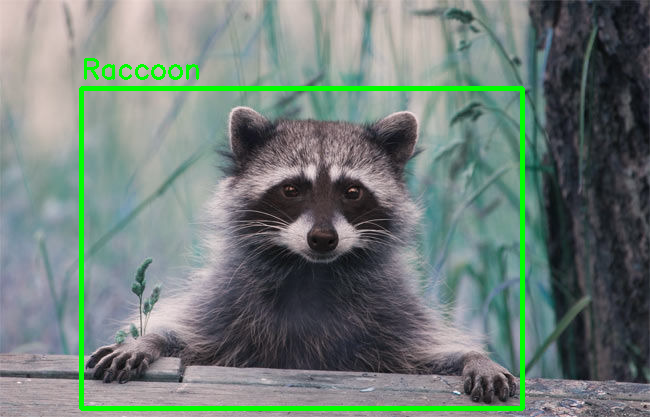

In [ ]:
draw_boxes("raccoon-1.jpg", ORIG_BASE_PATH)

In [ ]:
# grab all image paths in the input images directory
imagePaths = list(paths.list_images(ORIG_BASE_PATH))

# Lưu lại danh sách ảnh
list_img = []
for i in imagePaths:
  img = cv2.imread(i)
  list_img.append(img)

In [ ]:
print(len(imagePaths))
print(len(list_img))
print(list_img[3].shape)

200
200
(510, 347, 3)


## Lưu lại danh sách hộp

In [ ]:
all_gtBoxes = []

for (i, imagePath) in enumerate(imagePaths):
    filename = os.path.basename(imagePath)
    # Lọc các bounding boxes tương ứng với ảnh hiện tại
    selected_boxes = data_label_raccoon[data_label_raccoon.filename == filename]
    # Danh sách để lưu bounding boxes của ảnh này
    gtBoxes = []

    # Lặp qua từng bounding box và thêm vào gtBoxes
    for index, row in selected_boxes.iterrows():
        xMin = int(row['xmin'])
        yMin = int(row['ymin'])
        xMax = int(row['xmax'])
        yMax = int(row['ymax'])
        # Thêm bounding box vào danh sách gtBoxes
        gtBoxes.append((xMin, yMin, xMax, yMax))

    # Thêm danh sách gtBoxes của ảnh hiện tại vào all_gtBoxes
    all_gtBoxes.append(gtBoxes)

print(len(all_gtBoxes))

200


## Độ đo IoU

In [ ]:
def compute_iou(boxA, boxB):
	# Tính tọa độ giao nhau giữa hai hộp giới hạn
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	# Tính diện tích vùng giao nhau
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

	# Tính diện tích của từng hộp giới hạn
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

	# Tính IoU = (diện tích giao) / (diện tích hợp)
	iou = interArea / float(boxAArea + boxBArea - interArea)
	return iou

## Thực hiện tìm các các vùng tích tực và tiêu cực của tất cả ảnh

In [5]:
MAX_PROPOSALS = 2000  # giới hạn vùng đề xuất
MAX_POSITIVE = 30     # giới hạn vùng tích cực được lưu
MAX_NEGATIVE = 30     # giới hạn vùng tiêu cực được lưu
INPUT_DIMS = (224, 224)   # kích thước ảnh được truyền vào mạng MobildeNet

Sử dụng IoU để xác định khu vực nào chồng chéo đủ với các hộp trust và vùng nào không:

In [ ]:
# Khởi tạo số lượng ROIs tích cực và tiêu cực
totalPositive = 0
totalNegative = 0
count_img = 0

# Duyệt qua từng ảnh và bounding boxes tương ứng
for i, (img, gtBoxes) in enumerate(zip(list_img, all_gtBoxes)):
    # Khởi tạo bộ đếm cho ROIs tích cực và tiêu cực cho ảnh hiện tại
    positiveROIs = 0
    negativeROIs = 0
    count_img += 1
    print("Processing image", count_img, "/200")
    # Khởi tạo công cụ Selective Search
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(img)
    ss.switchToSelectiveSearchFast()

    # Lấy các vùng đề xuất (ROI)
    proposedRects = ss.process()

    for proposedRect in proposedRects[:MAX_PROPOSALS]:
        (propStartX, propStartY, propEndX, propEndY) = proposedRect

        roi = None
        outputPath = None
        isPositive = False

        # Duyệt qua tất cả các hộp giới hạn chuẩn (ground-truth bounding boxes) cho ảnh hiện tại
        for gtBox in gtBoxes:
            iou = compute_iou(gtBox, proposedRect)
            (gtStartX, gtStartY, gtEndX, gtEndY) = gtBox
            # Lưu lại những vùng có độ IoU > 0.7 và dưới 30 vùng
            if iou > 0.7 and positiveROIs < MAX_POSITIVE:
                roi = img[propStartY:propEndY, propStartX:propEndX]
                filename = "{}.jpg".format(totalPositive)
                outputPath = os.path.sep.join([POSITIVE_PATH, filename])

                positiveROIs += 1
                totalPositive += 1
                isPositive = True
                break

        if not isPositive:
            isNegative = True
            for gtBox in gtBoxes:
                iou = compute_iou(gtBox, proposedRect)
                fullOverlap = (propStartX >= gtStartX and propStartY >= gtStartY and
                               propEndX <= gtEndX and propEndY <= gtEndY)

                if iou >= 0.05 or fullOverlap:
                    isNegative = False
                    break

            if isNegative and negativeROIs < MAX_NEGATIVE:
                roi = img[propStartY:propEndY, propStartX:propEndX]
                filename = "{}.jpg".format(totalNegative)
                outputPath = os.path.sep.join([NEGATIVE_PATH, filename])

                negativeROIs += 1
                totalNegative += 1

        if roi is not None and outputPath is not None:
            if roi.size > 0:
                roi = cv2.resize(roi, INPUT_DIMS, interpolation=cv2.INTER_CUBIC)
                cv2.imwrite(outputPath, roi)

print("Tổng số ROI tích cực:", totalPositive)
print("Tổng số ROI tiêu cực:", totalNegative)


Processing image 1 /200
Processing image 2 /200
Processing image 3 /200
Processing image 4 /200
Processing image 5 /200
Processing image 6 /200
Processing image 7 /200
Processing image 8 /200
Processing image 9 /200
Processing image 10 /200


<ipython-input-14-af0ae0fcb09e>:15: RuntimeWarning: invalid value encountered in divide
  iou = interArea / float(boxAArea + boxBArea - interArea)


Processing image 11 /200
Processing image 12 /200
Processing image 13 /200
Processing image 14 /200
Processing image 15 /200
Processing image 16 /200
Processing image 17 /200
Processing image 18 /200
Processing image 19 /200
Processing image 20 /200
Processing image 21 /200
Processing image 22 /200
Processing image 23 /200
Processing image 24 /200
Processing image 25 /200
Processing image 26 /200
Processing image 27 /200
Processing image 28 /200
Processing image 29 /200
Processing image 30 /200
Processing image 31 /200
Processing image 32 /200
Processing image 33 /200
Processing image 34 /200
Processing image 35 /200
Processing image 36 /200
Processing image 37 /200
Processing image 38 /200
Processing image 39 /200
Processing image 40 /200
Processing image 41 /200
Processing image 42 /200
Processing image 43 /200
Processing image 44 /200
Processing image 45 /200
Processing image 46 /200
Processing image 47 /200
Processing image 48 /200
Processing image 49 /200
Processing image 50 /200


## Xây dựng model

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [7]:
INIT_LR = 1e-4
EPOCHS = 5
BS = 32

In [8]:
print("[INFO] loading images...")
imagePaths = list(paths.list_images(BASE_PATH))

data = []
labels = []

for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]

    image = load_img(imagePath, target_size=INPUT_DIMS)
    image = img_to_array(image)
    image = preprocess_input(image)

    data.append(image)
    labels.append(label)

[INFO] loading images...


In [10]:
# In số lượng dữ liệu mỗi lớp
print(len(data))
print(len(labels))
print(labels.count('no_raccoon'))
print(labels.count('raccoon'))

1475
1475
725
750


Text(0.5, 1.0, 'Số lượng hai lớp')

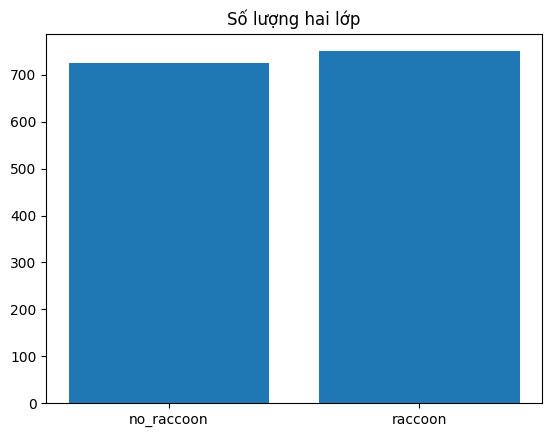

In [11]:
# trực quan hóa số lượng hai lớp
plt.bar(['no_raccoon', 'raccoon'], [labels.count('no_raccoon'), labels.count('raccoon')])
plt.title('Số lượng hai lớp')

In [9]:
data = np.array(data, dtype="float32")
labels = np.array(labels)
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [10]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=42)

aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [18]:
print(trainX.shape)
print(testX.shape)

(1180, 224, 224, 3)
(295, 224, 224, 3)


In [23]:
img_generator = aug.flow(trainX, trainY, batch_size=BS)

print(len(img_generator))

37


In [18]:
# Nạp MobileNetV2 loại bỏ các lớp Top (Head)
# Định nghĩa lớp Top mới để thay thế lớp Top đã loại bỏ của MobileNetV2
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor= Input(shape=(224, 224, 3)) )

NewTop = baseModel.output
NewTop = AveragePooling2D(pool_size=(7, 7))(NewTop)
NewTop = Flatten(name="flatten")(NewTop)
NewTop = Dense(128, activation="relu")(NewTop)
NewTop = Dropout(0.7)(NewTop)
NewTop = Dense(2, activation="sigmoid")(NewTop)  # Cập nhật kích thước đầu ra theo số lớp

# Tạo model bằng cách thay thế Top từ Top mới đã định nghĩa ở trên
model = Model(inputs=baseModel.input, outputs=NewTop)

# Đóng băng lớp cơ sở (base)
for layer in baseModel.layers:
    layer.trainable = False

# Biên dịch model
print("[INFO] Biên dịch model...")
opt = Adam(learning_rate=INIT_LR)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# train phần Top mới của network
print("[INFO] Đang huấn luyện phần Top (head) của mạng...")

H1 = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    epochs=EPOCHS
)

<ipython-input-18-11f48e9e416e>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor= Input(shape=(224, 224, 3)) )


[INFO] Biên dịch model...
[INFO] Đang huấn luyện phần Top (head) của mạng...
Epoch 1/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.6818 - loss: 0.6621
Epoch 2/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.9460 - loss: 0.2561
Epoch 3/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.9875 - loss: 0.1221
Epoch 4/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.9950 - loss: 0.0714
Epoch 5/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.9901 - loss: 0.0629


In [19]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

[INFO] evaluating network...
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step
              precision    recall  f1-score   support

  no_raccoon       1.00      0.99      0.99       145
     raccoon       0.99      1.00      0.99       150

    accuracy                           0.99       295
   macro avg       0.99      0.99      0.99       295
weighted avg       0.99      0.99      0.99       295



In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

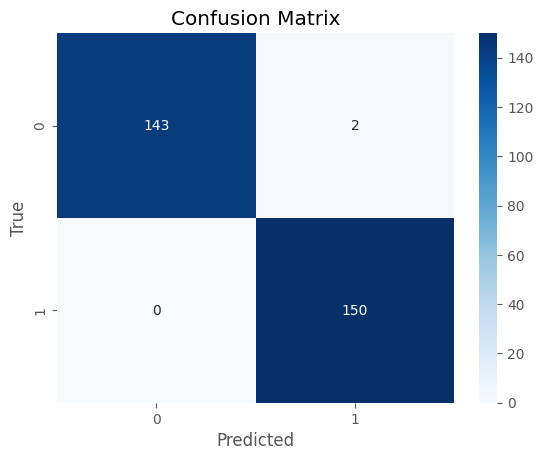

In [21]:
# Vẽ confusion matrix
sns.heatmap(confusion_matrix(testY[:,1], predIdxs), annot=True, cmap='Blues', fmt = ".0f")

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

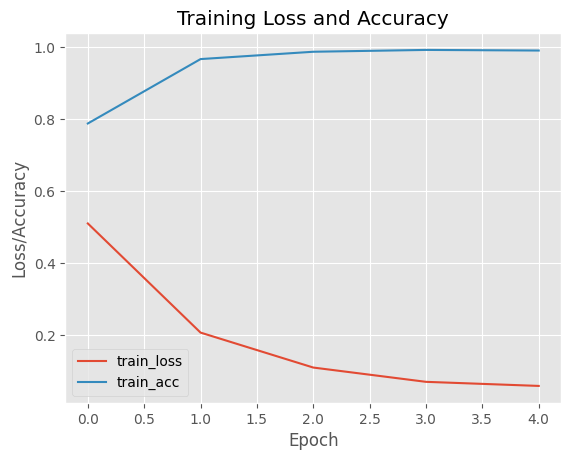

In [22]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H1.history["loss"], label="train_loss")

plt.plot(np.arange(0, N), H1.history["accuracy"], label="train_acc")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")


## Lưu Model

In [23]:
# define the path to the output model and label binarizer
MODEL_PATH = "/content/drive/MyDrive/Colab Notebooks/Computer Vision/R-CNN_with_Raccoon/Model/raccoon_detector.keras"
ENCODER_PATH = "/content/drive/MyDrive/Colab Notebooks/Computer Vision/R-CNN_with_Raccoon/Model/label_encoder.pickle"

In [24]:
print("[INFO] saving mask detector model...")
model.save(MODEL_PATH)
# serialize the label encoder to disk
print("[INFO] saving label encoder...")
f = open(ENCODER_PATH, "wb")
f.write(pickle.dumps(lb))
f.close()

[INFO] saving mask detector model...
[INFO] saving label encoder...
